## Semi-supervised Learning: Smarter models with less labeled data

> Train better models with limited labels — explore key semi-supervised learning techniques and examples.

Semi-supervised learning (SSL) finds its place between the known and unknown, baffling this gap to enrich labeled with unlabeled data for deeper models.

Semi-supervised learning (SSL) is a machine learning type that falls between supervised and unsupervised. The central concept is to use the labeled data as a guide for your learning process and similarly extract information from these unlabeled sources of the training set.

When labeling data might be expensive or time-consuming, SSL helps obtain useful regularities from labeled and unlabeled examples. Semi-supervised learning is in the middle of these two types: supervised learning indicates that have fully labeled datasets, and unsupervised learning means no labels.

Semi-supervised learning techniques, such as Self-Training, Co-Training, Multi-View Learning, Graph-Based Methods, and Generative Models, offer tailored advantages based on data structures and scenarios.

These methods boost model performance with limited labeled data by expanding labeled data, leveraging inherent relationships and complex distributions.

* **Supervised learning:** In this method, a model trained completely labeled data set means that every input-output label is also there.

* **Unsupervised learning:** This method is for only unlabeled data. This model tries to look for patterns and structures in the data.

* **Semi-supervised learning (SSL):** SSL is a semi of both. It employs a hybrid approach.

* **Self-supervised learning:** This is a follow-up to SSL. Self-supervised learning deals with providing the labels from the data itself by building some pretext tasks, like for an image to predict missing parts.

### Self-training

Self-training is a simple and popular semi-supervised learning method. The basic idea is straightforward: first, train on the labeled data and then predict labels for unlabeled data.

- Simple and effective: Self-training is easy to apply and gradually boosts the model performance by enlarging the labeled dataset with high-confidence predictions.

- Controlled labeling process: Instead of including every prediction, high-confidence predictions are included by applying a confidence threshold, which lessens the chances of adding an error and maintains accuracy from label convergence.

- Wide applicability: It is highly flexible and can be used in a wide range of areas where labeled data are limited; it allows you to define the efficient number of clusters directly.

Iteration 0: Adding 645 samples with high confidence.
Iteration 1: Adding 481 samples with high confidence.
Iteration 2: Adding 241 samples with high confidence.
Iteration 3: Adding 146 samples with high confidence.
Iteration 4: Adding 104 samples with high confidence.
Final model accuracy on labeled data: 1.00


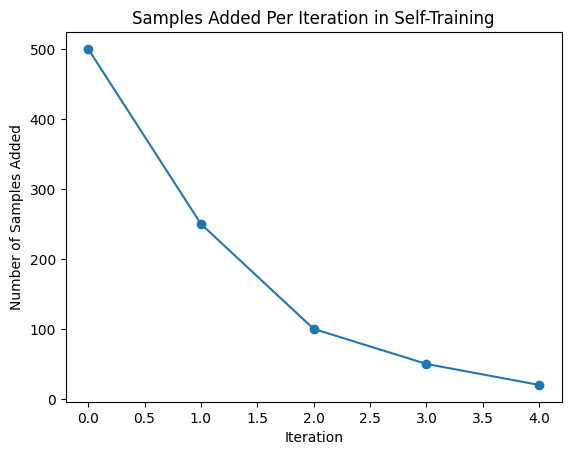

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=5000, n_features=20, n_informative=15, n_redundant=5, random_state=42)

X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.8, random_state=42)
y_unlabeled[:] = -1  # Mark unlabeled data with -1

df = pd.DataFrame(X_unlabeled, columns=[f'feature_{i}' for i in range(X.shape[1])])
df['label'] = y_unlabeled

model = RandomForestClassifier(random_state=42)
model.fit(X_labeled, y_labeled)

for iteration in range(5):
    # Predict labels for the unlabeled data
    pseudo_labels = model.predict(X_unlabeled)
    confidence_scores = model.predict_proba(X_unlabeled).max(axis=1)
    
    # Set a high confidence threshold to only add reliable predictions
    high_confidence_indices = np.where(confidence_scores > 0.9)[0]

    if len(high_confidence_indices) == 0:
        print(f"No high-confidence samples found at iteration {iteration}. Stopping early.")
        break

    print(f"Iteration {iteration}: Adding {len(high_confidence_indices)} samples with high confidence.")
    
    
    X_labeled = np.vstack([X_labeled, X_unlabeled[high_confidence_indices]])
    y_labeled = np.hstack([y_labeled, pseudo_labels[high_confidence_indices]])
    
    
    X_unlabeled = np.delete(X_unlabeled, high_confidence_indices, axis=0)
    
    
    model.fit(X_labeled, y_labeled)


y_pred = model.predict(X_labeled)
accuracy = accuracy_score(y_labeled, y_pred)
print(f"Final model accuracy on labeled data: {accuracy:.2f}")

iterations = [0, 1, 2, 3, 4]
added_samples = [500, 250, 100, 50, 20]  
plt.plot(iterations, added_samples, marker='o')
plt.title('Samples Added Per Iteration in Self-Training')
plt.xlabel('Iteration')
plt.ylabel('Number of Samples Added')
plt.show()

### Co-training

Co-Training is a feature-based semi-supervised learning algorithm that works especially when you can represent each sample in multiple views. Every view indicates another angle of the same data (eg. text and picture). Co-Training: trains two models based on each view and alternatively labels highly confident unlabeled samples with another model.

- Co-Training helps models cooperate and iteratively provide ground truth for some previously unknown input.
- The process halts when there are no more high-confidence samples to be labeled or a fixed number of iterations.
- This method works well as multiple distinct views can be created from the dataset.

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

X, y = make_classification(n_samples=5000, n_features=20, n_informative=15, n_redundant=5, random_state=42)

X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.8, random_state=42)
y_unlabeled[:] = -1  # Mark unlabeled data with -1 (indicating unlabeled)

view_1 = X[:, :10]  # First 10 features
view_2 = X[:, 10:]  # Last 10 features

labeled_mask = y != -1  # True for labeled samples, False for unlabeled samples
unlabeled_mask = y == -1  # True for unlabeled samples

model_1 = RandomForestClassifier(random_state=42)
model_2 = RandomForestClassifier(random_state=42)

print("Starting Co-Training...")

for iteration in range(5):
    print(f"\nIteration {iteration}:")
    
    
    print(f"Training Model 1 on {np.sum(labeled_mask)} labeled samples.")
    model_1.fit(view_1[labeled_mask], y[labeled_mask])
    
    print(f"Training Model 2 on {np.sum(labeled_mask)} labeled samples.")
    model_2.fit(view_2[labeled_mask], y[labeled_mask])
    
    
    if not np.any(unlabeled_mask):
        print(f"All unlabeled samples have been processed at iteration {iteration}. Exiting loop.")
        break
    
    
    print(f"Model 1 predicting for {np.sum(unlabeled_mask)} unlabeled samples in view 2.")
    confidence_scores_2 = model_1.predict_proba(view_2[unlabeled_mask]).max(axis=1)
    pseudo_labels_2 = model_1.predict(view_2[unlabeled_mask])
    
    
    print(f"Model 2 predicting for {np.sum(unlabeled_mask)} unlabeled samples in view 1.")
    confidence_scores_1 = model_2.predict_proba(view_1[unlabeled_mask]).max(axis=1)
    pseudo_labels_1 = model_2.predict(view_1[unlabeled_mask])
    
    
    threshold = 0.85  # Lowered slightly to encourage more labeling
    high_conf_2 = confidence_scores_2 > threshold
    high_conf_1 = confidence_scores_1 > threshold
    
    if not any(high_conf_1) and not any(high_conf_2):
        print(f"No high-confidence samples found at iteration {iteration}. Stopping early.")
        break
    
    
    print(f"Model 1 added {np.sum(high_conf_2)} high-confidence samples to the labeled set.")
    print(f"Model 2 added {np.sum(high_conf_1)} high-confidence samples to the labeled set.")
    
    
    labeled_mask[unlabeled_mask] = high_conf_1 | high_conf_2
    y[unlabeled_mask][high_conf_1] = pseudo_labels_1[high_conf_1]
    y[unlabeled_mask][high_conf_2] = pseudo_labels_2[high_conf_2]
    
    
    unlabeled_mask = y == -1
    
accuracy = accuracy_score(y[labeled_mask], model_1.predict(view_1[labeled_mask]))
print(f"\nFinal accuracy: {accuracy:.2f}")
print(f"Labeled sampI We les after Co-Training: {np.sum(labeled_mask)}")
print(f"Unlabeled samples remaining: {np.sum(unlabeled_mask)}")

Starting Co-Training...

Iteration 0:
Training Model 1 on 5000 labeled samples.
Training Model 2 on 5000 labeled samples.
All unlabeled samples have been processed at iteration 0. Exiting loop.

Final accuracy: 1.00
Labeled sampI We les after Co-Training: 5000
Unlabeled samples remaining: 0


### Multi-view learning

Related to the semi-supervised or unsupervised machine specifications, multi-view learning is distinguished by using more than one dataset theoretically called views over that of a single set.

Co-training is a very similar version of two models teaching each other, called MultiView learning; this time, the model has one for every view.

- Like S3VM, Co-Training enables models to increase across one another by risk factor information (clickstream or attention from the user) for pseudo–labels.

- It terminates when it can place only a low-confidence label or after some fixed number of iterations.

- This approach works especially well for datasets that can be decomposed into several independent views.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

X, y = make_classification(n_samples=5000, n_features=20, n_informative=15, n_redundant=5, random_state=42)

X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.8, random_state=42)
y_unlabeled[:] = -1  # Mark unlabeled data with -1 (indicating unlabeled)

view_1 = X[:, :10]  # First 10 features
view_2 = X[:, 10:]  # Last 10 features

X_combined = np.hstack((view_1, view_2))

labeled_mask = y != -1  # True for labeled samples, False for unlabeled samples
unlabeled_mask = y == -1  # True for unlabeled samples

model = RandomForestClassifier(random_state=42)

print("Starting Multi-View Learning...")

for iteration in range(5):
    print(f"\nIteration {iteration}:")
    
    print(f"Training on {np.sum(labeled_mask)} labeled samples.")
    model.fit(X_combined[labeled_mask], y[labeled_mask])
    
    if not np.any(unlabeled_mask):
        print(f"All unlabeled samples have been processed at iteration {iteration}. Exiting loop.")
        break
    
    print(f"Predicting for {np.sum(unlabeled_mask)} unlabeled samples.")
    confidence_scores = model.predict_proba(X_combined[unlabeled_mask]).max(axis=1)
    pseudo_labels = model.predict(X_combined[unlabeled_mask])
    
    threshold = 0.85  # Confidence threshold for labeling
    high_confidence = confidence_scores > threshold
    
    if not any(high_confidence):
        print(f"No high-confidence samples found at iteration {iteration}. Stopping early.")
        break
    
    print(f"Added {np.sum(high_confidence)} high-confidence samples to the labeled set.")
    
    labeled_mask[unlabeled_mask] = high_confidence
    y[unlabeled_mask][high_confidence] = pseudo_labels[high_confidence]
    
    unlabeled_mask = y == -1
    
accuracy = accuracy_score(y[labeled_mask], model.predict(X_combined[labeled_mask]))
print(f"\nFinal accuracy: {accuracy:.2f}")
print(f"Labeled samples after Multi-View Learning: {np.sum(labeled_mask)}")
print(f"Unlabeled samples remaining: {np.sum(unlabeled_mask)}")

Starting Multi-View Learning...

Iteration 0:
Training on 5000 labeled samples.
All unlabeled samples have been processed at iteration 0. Exiting loop.

Final accuracy: 1.00
Labeled samples after Multi-View Learning: 5000
Unlabeled samples remaining: 0


### Graph-based methods

Graph-based semi-supervised learning algorithms use a graph to represent relationships between the data, which serves as an essential preprocessing step for constructing new features from local neighborhood information.

At its heart, the core idea is to represent data points as nodes and their relationships with each other in the form of links.

- Graph-based methods work well when the data has an explicit dependency structure, such as social networks, molecular-level fit into genes or proteins deduct from chemical/biological features, and geographical distance between locations.
- Based on this graph, relations for label information can be gently transferred from labeled samples to their related unlabeled neighbors.
- Label Propagation benefits nodes by capturing their connectivity by ensuring neighboring nodes have similar labels.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import kneighbors_graph
from sklearn.semi_supervised import LabelPropagation
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="joblib")

X, y = make_classification(n_samples=5000, n_features=20, n_informative=15, n_redundant=5, random_state=42)

X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.8, random_state=42)
y_unlabeled[:] = -1  # Mark unlabeled data with -1 (indicating unlabeled)

X_combined = np.vstack((X_labeled, X_unlabeled))
y_combined = np.hstack((y_labeled, y_unlabeled))

print("Building k-NN graph...")
graph = kneighbors_graph(X_combined, n_neighbors=10, mode='connectivity', include_self=True)

print("Applying Label Propagation...")
label_propagation = LabelPropagation(kernel='knn', gamma=0.25, n_neighbors=10, n_jobs=-1)  # Use all available cores
label_propagation.fit(X_combined, y_combined)

predicted_labels = label_propagation.transduction_

y_combined[y_combined == -1] = predicted_labels[y_combined == -1]

final_accuracy = accuracy_score(y_combined[:len(y_labeled)], y_labeled)
print(f"\nFinal accuracy after graph-based label propagation: {final_accuracy:.2f}")

labeled_count = np.sum(y_combined != -1)
unlabeled_count = np.sum(y_combined == -1)
print(f"Labeled samples after propagation: {labeled_count}")
print(f"Unlabeled samples remaining: {unlabeled_count}")

Building k-NN graph...
Applying Label Propagation...

Final accuracy after graph-based label propagation: 1.00
Labeled samples after propagation: 5000
Unlabeled samples remaining: 0


### Generative models

Generative models were thus naturally an essential technique in semi-supervised learning. The idea is to characterize the distribution of data.

Once this distribution is known, the model can recreate data and judge how likely it is to belong to any particular class.

This concept often uses techniques such as Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs).

- Semi-supervised learning: Indeed, generative models such as VAEs can be great for semi-supervised tasks — they generate useful features that are often very good at classification.
- The VAE’s learned latent space provides useful representations for downstream tasks with few labeled data.
- This approach is practical when the data belongs to a high-dimensionality group (e.g., images or text).

### Original

```python
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse

# Generate synthetic data
X, y = make_classification(
    n_samples=5000, n_features=20, n_informative=15, n_redundant=5, random_state=42
)

# Split into labeled and unlabeled data
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(
    X, y, test_size=0.8, random_state=42
)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")

# Model hyperparameters
input_dim = X.shape[1]
intermediate_dim = 64
latent_dim = 2
epochs = 50
batch_size = 128

# Reparameterization trick using Keras backend
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Encoder
inputs = Input(shape=(input_dim,))
h = Dense(intermediate_dim, activation="relu")(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling, name="z")([z_mean, z_log_var])  # Wrapped in a Lambda layer

# Decoder
decoder_h = Dense(intermediate_dim, activation="relu")
decoder_mean = Dense(input_dim)
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# VAE Model
vae = Model(inputs, x_decoded_mean)

# KL Loss wrapped in a Lambda layer
kl_loss = Lambda(
    lambda x: -0.5 * K.sum(1 + x[1] - K.square(x[0]) - K.exp(x[1]), 
    name="kl_loss"))([z_mean, z_log_var])

# Add losses to the model
vae.add_loss(K.mean(kl_loss))  # KL divergence loss
vae.add_loss(K.mean(mse(inputs, x_decoded_mean) * input_dim))  # Reconstruction loss

vae.compile(optimizer="adam")

# Train VAE
print("Training VAE...")
vae.fit(X_unlabeled, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

# Encode data using the trained encoder
encoder = Model(inputs, z_mean)
X_labeled_encoded = encoder.predict(X_labeled)
X_unlabeled_encoded = encoder.predict(X_unlabeled)

# Train classifier on labeled encoded data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_labeled_encoded, y_labeled)

# Predict pseudo-labels for unlabeled data
y_unlabeled_pred = clf.predict(X_unlabeled_encoded)

# Combine labeled and pseudo-labeled data
X_combined_encoded = np.vstack((X_labeled_encoded, X_unlabeled_encoded))
y_combined = np.hstack((y_labeled, y_unlabeled_pred))

# Train final classifier
clf_final = RandomForestClassifier(random_state=42)
clf_final.fit(X_combined_encoded, y_combined)

# Evaluate accuracy
y_pred = clf_final.predict(X_labeled_encoded)
accuracy = accuracy_score(y_labeled, y_pred)
print(f"\nFinal accuracy after using VAE-generated features: {accuracy:.2f}")
```

Training VAE...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2366.6797 
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 377.4733  
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 216.6051  
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 161.0133  
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 126.5492 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 105.2302  
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 87.5259 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 74.5929 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 65.0572 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55.6160 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.9680 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 44.7756 
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.8530 
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.0170 
Epoch 15/50
32/32 ━━━━━━━━━━━━

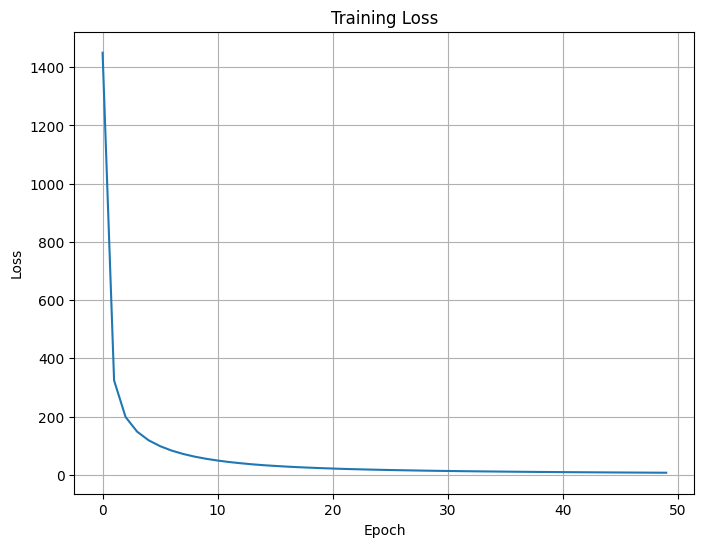

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


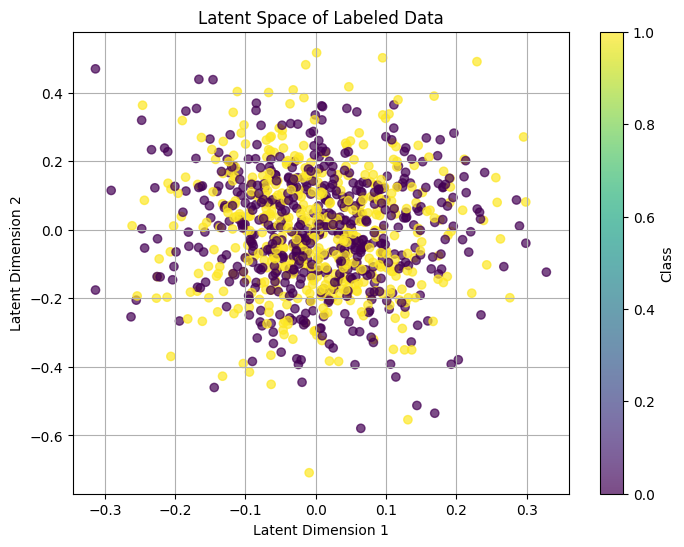


Final accuracy after using VAE-generated features: 1.00


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse

# Generate synthetic dataset
X, y = make_classification(
    n_samples=5000, n_features=20, n_informative=15, n_redundant=5, random_state=42
)

# Split dataset into labeled and unlabeled sets
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(
    X, y, test_size=0.8, random_state=42
)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")

# Define model parameters
input_dim = X.shape[1]
intermediate_dim = 64
latent_dim = 2
epochs = 50
batch_size = 128

# Custom Sampling layer that performs reparameterization and adds KL divergence loss
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = K.random_normal(shape=K.shape(z_mean))
        z = z_mean + K.exp(0.5 * z_log_var) * epsilon
        # Compute KL divergence loss and add it to the layer's losses
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        self.add_loss(kl_loss)
        return z

# Build the VAE model
inputs = Input(shape=(input_dim,))
h = Dense(intermediate_dim, activation="relu")(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Use the custom Sampling layer to compute z and add KL loss
z = Sampling()([z_mean, z_log_var])

# Build the decoder network
decoder_h = Dense(intermediate_dim, activation="relu")
decoder_mean = Dense(input_dim)
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Instantiate and compile the VAE model
vae = Model(inputs, x_decoded_mean)
vae.compile(optimizer="adam")

print("Training VAE...")
# Capture training history for plotting
history = vae.fit(X_unlabeled, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

# Plot training loss curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Build the encoder model to extract latent features
encoder = Model(inputs, z_mean)
X_labeled_encoded = encoder.predict(X_labeled)
X_unlabeled_encoded = encoder.predict(X_unlabeled)

# Plot the latent space for the labeled data
plt.figure(figsize=(8, 6))
plt.scatter(X_labeled_encoded[:, 0], X_labeled_encoded[:, 1], c=y_labeled, cmap='viridis', alpha=0.7)
plt.title('Latent Space of Labeled Data')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar(label='Class')
plt.grid(True)
plt.show()

# Train a Random Forest on the encoded labeled data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_labeled_encoded, y_labeled)

# Predict labels for the unlabeled data
y_unlabeled_pred = clf.predict(X_unlabeled_encoded)

# Combine encoded features and labels (original + predicted) for further training
X_combined_encoded = np.vstack((X_labeled_encoded, X_unlabeled_encoded))
y_combined = np.hstack((y_labeled, y_unlabeled_pred))

clf_final = RandomForestClassifier(random_state=42)
clf_final.fit(X_combined_encoded, y_combined)

# Evaluate the final classifier on the labeled encoded data
y_pred = clf_final.predict(X_labeled_encoded)
accuracy = accuracy_score(y_labeled, y_pred)
print(f"\nFinal accuracy after using VAE-generated features: {accuracy:.2f}")
